# Classify Fashion Object With Images Using PyTorch and Neural Network

Using FASHION-MNIST datasets with hundreds thousands of clothes images for classification. Apply ML models in PyTorch framework and 4-layers Neural Network. Implement dropout for overfitting situations.

In [ ]:
# Download pytorch
!pip3 install torch torchvision torchaudio

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # in case kernel die

In [2]:
# Check download pytorch successfully with version
import torch
torch.__version__

'1.13.0+cpu'

## Download and pre-process dataset

In [3]:
from torch import nn, optim 
import torch.nn.functional as F
from torchvision import datasets, transforms

# transformer for image standardization
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# download Fashion-MNIST, use dataloader, each time load 64 images without order
trainset = datasets.FashionMNIST('dataset/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# download Fashion-MNIST use it for test set
testset = datasets.FashionMNIST('dataset/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

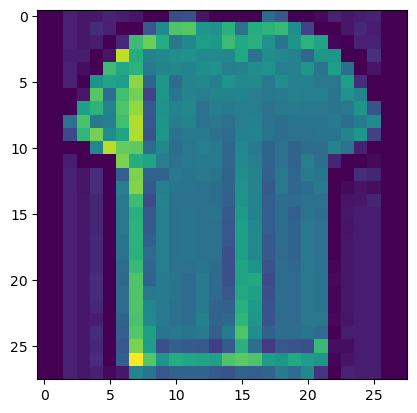

In [4]:
# show the image
import matplotlib.pyplot as plt
%matplotlib inline

image, label = next(iter(trainloader))

imagedemo = image[10]
imagedemolabel = label[10]

imagedemo = imagedemo.reshape((28,28))
plt.imshow(imagedemo)

Image Label:<br>
0 - T-shirt<br>
1 - Trouse<br>
2 - Pullover<br>
3 - Dress<br>
4 - Coat<br>
5 - Sandal<br>
6 - Shirt<br>
7 - Sneaker<br>
8 - Bag<br>
9 - Ankle Boot

## 4-Layer Fully Convolutional Neural Network Construction

In [5]:
# input: 28 * 28 = 784 pixels
# First layer: 256 nodes, Second layer: 128 nodes, Third layer: 64 nodes, can modify the node number
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
    
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1) # classification
        
        return x

In [7]:
# Instantiate the classifier
model = Classifier()

# Define the loss function as negative log loss function
criterion = nn.NLLLoss()

# Adam optimizer, learning rate as 0.005
optimizer = optim.Adam(model.parameters(), lr=0.003)

# train 15 times
epochs = 15

# store the training losses and testing losses in two list for visualization
train_losses, test_losses = [], []

print('Start training')

# for each training process
for e in range(epochs):
    running_loss = 0
    
    # for all images in the train loader
    for images, labels in trainloader:
        # set 0 of the gradient descent derivative
        optimizer.zero_grad()
        
        # classify 64 images and calculate the loss
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    # after learning the dataset
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
            # close dropout
            model.eval()
            
            # all images in the test set
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        model.train()
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Training: {}/{}...".format(e + 1, epochs),
              "Training loss: {:.3f}...".format(running_loss/len(trainloader)),
              "Testing loss: {:.3f}...".format(test_loss/len(testloader)),
              "Model Classification Accuracy: {:.3f}".format(accuracy/len(testloader)))

Start training
Training: 1/15... Training loss: 0.514... Testing loss: 0.454... Model Classification Accuracy: 0.831
Training: 2/15... Training loss: 0.392... Testing loss: 0.393... Model Classification Accuracy: 0.853
Training: 3/15... Training loss: 0.353... Testing loss: 0.389... Model Classification Accuracy: 0.860
Training: 4/15... Training loss: 0.327... Testing loss: 0.402... Model Classification Accuracy: 0.856
Training: 5/15... Training loss: 0.310... Testing loss: 0.386... Model Classification Accuracy: 0.860
Training: 6/15... Training loss: 0.300... Testing loss: 0.357... Model Classification Accuracy: 0.875
Training: 7/15... Training loss: 0.288... Testing loss: 0.361... Model Classification Accuracy: 0.874
Training: 8/15... Training loss: 0.283... Testing loss: 0.364... Model Classification Accuracy: 0.875
Training: 9/15... Training loss: 0.273... Testing loss: 0.349... Model Classification Accuracy: 0.878
Training: 10/15... Training loss: 0.263... Testing loss: 0.385... M

## Validate the Model Performance

#### Visulization of the Training loss and Validation loss

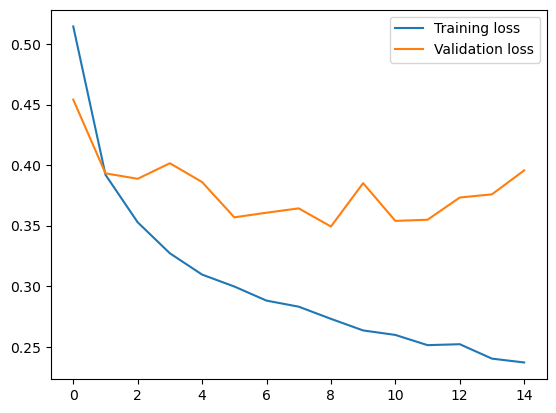

In [9]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

## Use Dropout Method for Preventting Overfitting

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # construct dropout, ramdonly turn off 20% nerouns
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [12]:
# Re-instantiate the classifier, repeat the process with drop out and see the effect
model = Classifier()

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 15

train_losses, test_losses = [], []

print('Start training')
for e in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
 
            model.eval()
            
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                                       
        model.train()

        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Training: {}/{}...".format(e + 1, epochs),
              "Training loss: {:.3f}...".format(running_loss/len(trainloader)),
              "Testing loss: {:.3f}...".format(test_loss/len(testloader)),
              "Model Classification Accuracy: {:.3f}".format(accuracy/len(testloader)))

Start training
Training: 1/15... Training loss: 0.613... Testing loss: 0.478... Model Classification Accuracy: 0.832
Training: 2/15... Training loss: 0.485... Testing loss: 0.438... Model Classification Accuracy: 0.842
Training: 3/15... Training loss: 0.454... Testing loss: 0.431... Model Classification Accuracy: 0.852
Training: 4/15... Training loss: 0.435... Testing loss: 0.396... Model Classification Accuracy: 0.856
Training: 5/15... Training loss: 0.427... Testing loss: 0.430... Model Classification Accuracy: 0.845
Training: 6/15... Training loss: 0.417... Testing loss: 0.393... Model Classification Accuracy: 0.861
Training: 7/15... Training loss: 0.405... Testing loss: 0.394... Model Classification Accuracy: 0.862
Training: 8/15... Training loss: 0.405... Testing loss: 0.403... Model Classification Accuracy: 0.856
Training: 9/15... Training loss: 0.394... Testing loss: 0.413... Model Classification Accuracy: 0.855
Training: 10/15... Training loss: 0.389... Testing loss: 0.384... M

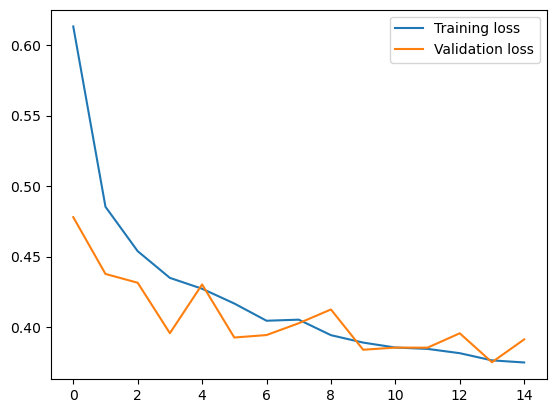

In [13]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend()

The image is classied as a T-shirt，the probability is 95.08011937141418%


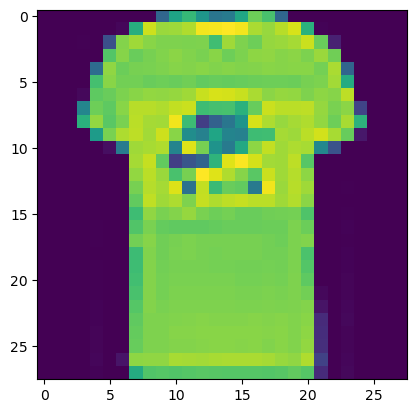

In [18]:
model.eval()
dataiter = iter(testloader)
images, labels = next(dataiter)
img = images[10]
img = img.reshape((28,28)).numpy()
plt.imshow(img)

img = torch.from_numpy(img)
img = img.view(1, 784)

# Classify the image
with torch.no_grad():
    output = model.forward(img)
ps = torch.exp(output)

top_p, top_class = ps.topk(1, dim=1)
labellist = ['T-shirt','Trouse','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
prediction = labellist[top_class]
probability = float(top_p)
print(f'The image is classied as a {prediction}，the probability is {probability*100}%')